In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = None
import math
import os
import scipy
from itertools import compress
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
import statsmodels.stats.api as sms

def folder_to_list(folder_path):
    #move into specified folder
    os.chdir(folder_path)
    #make a list of all the excel files in the folder
    files = [x for x in os.listdir() if os.path.splitext(x)[1] == '.xlsx']
    #creates dictionary corresponding to each file in the folder
    all_files = {}
    for file in files:
        all_files[f'{file}'] = pd.read_excel(file, sheet_name = None)
    #change dictionary to dataframe
    #final = pd.DataFrame(all_files)
    #returns dataframe containing each sheet of each file in the folder
    return all_files
    
       
#function to turn a single sheet from a dataframe into a dataframe of all the cells with processed deltaF/F0
def pre_process_sheet(name, sheet):
        #start processing data starting at 0.5 seconds or greater
    start_index = np.where(sheet['Time [s]'] > 0.5)[0][0]
        #cut off last 2 data points (usually corresponds to dropoff)
    end_index = -2
        #get time array
    times = np.array(sheet['Time [s]'][start_index:end_index])
        #get background array (1st ROI)
    background = np.array(sheet.iloc[start_index:end_index,5])
    cells = {}
    excluded = {}
        #for loop to cycle through each subsequent ROI in a sheet, will add to the \cells\ dictionary
    for x in range(6, len(sheet.columns)):
            #access ROI
        roi = np.array(sheet.iloc[start_index:end_index,x])
            #subtracts background
        background_subtracted = roi-background
            #starts calculating standard deviations with a sliding window of 20 values
        std_window = 20
            #calculates specific locations where the background subtracted ROI has low variance (low-pass filter)
            #low variance is determined via anything with a standard deviation less than the 40th percentile of all standard deviations within this trace
        ts = pd.Series(background_subtracted)
        std_percentile = 40 # percent
        rw = ts.rolling(window=std_window).std().fillna(np.inf)
        cutoff = np.percentile(rw, std_percentile)
        low_std_indices = np.where(np.array(rw.fillna(cutoff+1)) < cutoff)
        if times[low_std_indices].size <= 10:
            excluded[f'{x-5}'] = {'trace': [np.nan], 'Exclusion criteria': 'Pre-process exclusion: Too noisy during rolling window calculation'}
            continue
            #fits 3rd degree polynomial to the low-pass filter
        deg = 3
        p = np.polyfit(times[low_std_indices], background_subtracted[low_std_indices], deg)
            #p = np.polyfit(times, background_subtracted, deg)
        pf = np.poly1d(p)
            #subtract out the 3rd degree polynomial fit to the low pass filter (also 1st subtraction of F0)
        photobleach_corrected = background_subtracted-pf(times)
            #calculates F0 for the division, F0 is based on low-pass filter
        f0 = abs(np.mean(background_subtracted[low_std_indices]))
            #divides the polynomial fit subtracted value by F0 for deltaF/F0
        process = (photobleach_corrected)/f0
            #appends the \processed\ values into the \cells\ dictionary
        cells[f'{x-5}'] = process
        #converts \cells\ dictionary to dataframe for easier manipulation
        
    pre_process_cells = pd.DataFrame(cells)
    pre_process_excluded = pd.DataFrame(excluded)
    sampling = int(1/np.mean(np.diff(times)))
    return pre_process_cells, sampling, pre_process_excluded    
     
        
        
    #function to collect # of spikes, mean of spike heights (subtracted from value immediately before), and std of spike heights
def post_process_df(pre_process_cells, sampling):
        #empty cell dictionary to start
    cells = {}
    excluded = {}
        #loop through all the cells loaded in from the 'pre_process_cells' dataframe
    for x in pre_process_cells.keys():
        if np.isnan(pre_process_cells[x]).any():
            excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: nan in trace'}
            continue
        burst = True
        slow = False

        if pre_process_cells[x][np.argmax(np.absolute(pre_process_cells[x]))] > 0:
            valence = 1
        if pre_process_cells[x][np.argmax(np.absolute(pre_process_cells[x]))] < 0:
            valence = -1

        
            #calculates the absolute value of the mean of the entire trace-- if absolute value of the mean is less than 0.001, there were probably no spikes (can exclude)
        if np.mean(np.absolute(pre_process_cells[x])) < 0.001:            
            excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: Absolute mean too small-- no spikes'}
            continue
                
            #starts calculating standard deviations with a sliding window of 20 values
            #specifically finding points where standard deviation is less than the 40th percentile of all standard deviations in the trace
        std_percentile = 40 # percent
        std_window = 20
        ts = pd.Series(pre_process_cells[x])
        rw = ts.rolling(window=std_window).std().fillna(np.inf)
        cutoff = np.percentile(rw, std_percentile)
        low_std_indices = np.where(np.array(rw.fillna(cutoff+1)) < cutoff)
            
            #calculate the root mean squared within regions with low standard deviation, set as 'noise'
            #given that the expected value is 0 for baseline, noise is calculated as root mean square
        noise = np.sqrt(np.mean(np.absolute(pre_process_cells[x][low_std_indices[0]])**2))
            #determines the minimum height requirement as 16 times the standard deviation in regions with only noise
        ######COME BACK TO THIS, TUNE HEIGHT THRESHOLD AS NECESSARY, LOWERED FROM 10 to 5###############
        height_threshold = 5*noise
            #collecting exact indices of spikes and spike heights
        indices, heights = find_peaks(np.absolute(pre_process_cells[x]), height = height_threshold)
        calc_height = np.array(pre_process_cells[x][indices])
        
        prominences2 = peak_prominences(np.absolute(pre_process_cells[x]), indices)[0]
        if len(prominences2) > 0:
            comparison = (-1*math.log10(np.max(prominences2)))
            to_remove = []
            for q in range(len(prominences2)):
                if (-1*math.log10(prominences2[q])) >= 2.5*comparison:
                    to_remove.append(q)
            indices = np.delete(indices, to_remove)
            calc_height = np.delete(calc_height, to_remove)
           
        
        if valence > 0:
            if sum(num < 0 for num in (pre_process_cells[x][indices])) >= 2:               
                excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: Too flippy'}
                continue
        if valence < 0:
            if sum(num > 0 for num in (pre_process_cells[x][indices])) >= 2:                 
                excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: Too flippy'}
                continue
        
            
            
            #determines how to analyze data based on sampling rate and protocol (length of recording)
            
            #if sampling rate is ~200Hz
        if sampling < 300:
            
                #when sampling rate is 200Hz, burst stimulation is always in the 100-150 indices
            burst_window = [100, 140]
            burst_indices = []
                #collects the exact locations of spikes within the burst stimulation window
            for a in indices:
                if a >=burst_window[0] and a <=burst_window[1]:
                    burst_indices.append(a)
                #determines if there is only burst stimulation or slow stimulation as well
                #if the length of recording is greater than 400 samples, then the cell received both burst stimulation and slow stimulation
            if len(pre_process_cells[x]) > 400:
                slow = True
                    #slow stimulation window is always (when sampling at 200Hz) at the 200-400 indices
                slow_window = [200, 400]
                slow_indices = []
                    #collects the exact locations of spikes within the slow stimulation window
                for a in indices:
                    if a >=slow_window[0] and a <=slow_window[1]:
                        slow_indices.append(a)
            #if sampling rate is ~400Hz
        else:
                #when sampling rate is 400Hz, burst stimulation is always in the 200-300 indices
            burst_window = [200,280]
            burst_indices = []
                #collects the exact locations of spikes within the burst stimulation window
                #no current protocols sample at 400Hz and include slow stimulation
            for a in indices:
                if a >=burst_window[0] and a <=burst_window[1]:
                    burst_indices.append(a)
        if np.absolute(np.mean(pre_process_cells[x][burst_indices])) < noise:            
            excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: flipflop during burst'}
            continue
        too_many_flops = 0
        og_length = len(burst_indices)
        for n in burst_indices.copy():
            if valence > 0:
                if pre_process_cells[x][n] < 0:
                    burst_indices.remove(n)
                    ind = np.where(indices == n)
                    indices = np.delete(indices, ind)
                    calc_height = np.delete(calc_height, ind)
                    too_many_flops += 1
            if valence < 0:
                if pre_process_cells[x][n] > 0:
                    burst_indices.remove(n)
                    ind = np.where(indices == n)
                    indices = np.delete(indices, ind)
                    calc_height = np.delete(calc_height, ind)
                    too_many_flops += 1
        if too_many_flops >= 2:            
            excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: flipflop during burst'}
            continue
        burst_slopes = []
        for m in burst_indices.copy():
            x_vals = np.arange(m, m+3)
            y_vals = 10**(pre_process_cells[x][x_vals])
            deg = 1
            p = np.polyfit(x_vals, y_vals, deg)
            pf = np.poly1d(p)
            burst_slopes.append([m, p[0]])
        slopes = pd.DataFrame(burst_slopes, columns = ['ind', 'slope'])
        original = len(burst_indices)
        removed = 0
        if valence > 0:
            direction = -1
        if valence < 0:
            direction = 1
        to_remove = []
        for n in slopes.index:
            if direction == 1:
                if slopes.loc[n]['slope'] < 0:
                    burst_indices.remove(slopes.loc[n]['ind'])
                    ind = np.where(indices == slopes.loc[n]['ind'])
                    indices = np.delete(indices, ind)
                    calc_height = np.delete(calc_height, ind)
                    removed+=1
                    to_remove.append(n)
                    continue
            if direction == -1:
                if slopes.loc[n]['slope'] > 0:
                    burst_indices.remove(slopes.loc[n]['ind'])
                    ind = np.where(indices == slopes.loc[n]['ind'])
                    indices = np.delete(indices, ind)
                    calc_height = np.delete(calc_height, ind)
                    removed+=1
                    to_remove.append(n)
                    continue        
        slopes = slopes.drop(to_remove)
        prominences2 = peak_prominences(np.absolute(pre_process_cells[x]), burst_indices)[0]
        if len(prominences2) > 0:
            comparison = (-1*math.log10(np.max(prominences2)))
            to_remove = []
            for q in range(len(prominences2)):
                if (-1*math.log10(prominences2[q])) >= 1.5*comparison:
                    current_fast = burst_indices[q]
                    ind = np.where(indices == current_fast)
                    indices = np.delete(indices, ind)
                    calc_height = np.delete(calc_height, ind)
                    to_remove.append(q)
            burst_indices = np.delete(burst_indices, to_remove)
            prominences2 = np.delete(prominences2, to_remove)
       
        if removed >= original/2:            
            excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: back and forth'}
            continue
        if len(burst_indices) < 1 or len(burst_indices) > 15:
            if slow != True:
                if len(burst_indices) < 1:                  
                    excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: less than 1 spike in burst window'}
                if len(burst_indices) > 15:                      
                    excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: more than 13 spikes in burst window'}
                continue 
            #within the burst stimulation, exclude cells that go both positive and negative by comparing the deltaF at the 2nd spike and the 3rd spike
            #also collect if the cell is positive going or negative going

            #within burst stimulation, exclude cells that hyperpolarize before depolarizing 
            #based on spike shape, these are probably not the type of cell we'd want/deltaFs are always significantly different from the other cells in the same cohort
        if slow != True:
            left_of_index = np.array(burst_indices[1:-1]) - 1
            if valence > 0:
                if sum(num < (0-(valence*noise*2.5)) for num in (pre_process_cells[x][left_of_index])) >= 3:                                                        
                    excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: hyperpolarizing one spot immediately before spike in burst window-- likely weird cell type'}
                    continue
            else:
                if sum(num > (0-(valence*noise*2.5)) for num in (pre_process_cells[x][left_of_index])) >= 3:                                          
                    excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: hyperpolarizing one spot immediately before spike in burst window-- likely weird cell type'}
                    continue

                #same as above, within burst stimulation, exclude cells that hyperpolarize before depolarizing, but now checking at the spot 2 indices before instead of directly before
            left2_of_index = np.array(burst_indices[1:-1]) - 2
            if valence > 0:
                if sum(num < (0-(valence*noise*2.5)) for num in (pre_process_cells[x][left2_of_index])) >= 3:                                   
                    excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: hyperpolarizing two spots immediately before spike in burst window-- likely weird cell type'}
                    continue
            else:
                if sum(num > (0-(valence*noise*2.5)) for num in (pre_process_cells[x][left2_of_index])) >= 3:                       
                    excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: hyperpolarizing two spots immediately before spike in burst window-- likely weird cell type'}
                    continue
                    
            #looks at the width of each spike within the burst stimulation
            #if the width of each spike is greater than 10 indices (aka a very wide spike without subsequent spikes being stimulated)
            #then exclude
        spike_number = int(indices.size)
            #calculate the maximum change in the burst stimulation
        burst_max = valence * max(abs(pre_process_cells[x][burst_indices]))
            
            #if protocol included slow stimulation
        if slow:
            for n in slow_indices.copy():
                if valence > 0:
                    if pre_process_cells[x][n] < 0:
                        slow_indices.remove(n)
                        ind = np.where(indices == n)
                        indices = np.delete(indices, ind)
                        calc_height = np.delete(calc_height, ind)
                if valence < 0:
                    if pre_process_cells[x][n] > 0:
                        slow_indices.remove(n)
                        ind = np.where(indices == n)
                        indices = np.delete(indices, ind)
                        calc_height = np.delete(calc_height, ind)
            slow_slopes = []
            for m in slow_indices:
                x_vals = np.arange(m, m+15)
                y_vals = (pre_process_cells[x][x_vals])
                deg = 3
                p = np.polyfit(x_vals, y_vals, deg)
                pf = np.poly1d(p)
                # Take the derivative of the polynomial
                dpf = np.polyder(pf)
                slow_slopes.append([m, dpf(m)])
            slopes = pd.DataFrame(slow_slopes, columns = ['ind', 'slope'])
            to_remove = []
            for n in slopes.index:
                if direction == 1:
                    if slopes.loc[n]['slope'] < 0.0:
                        slow_indices.remove(slopes.loc[n]['ind'])
                        ind = np.where(indices == slopes.loc[n]['ind'])
                        indices = np.delete(indices, ind)
                        calc_height = np.delete(calc_height, ind)
                        to_remove.append(n)
                        continue
                if direction == -1:
                    if slopes.loc[n]['slope'] > 0.0:
                        slow_indices.remove(slopes.loc[n]['ind'])
                        ind = np.where(indices == slopes.loc[n]['ind'])
                        indices = np.delete(indices, ind)
                        calc_height = np.delete(calc_height, ind)
                        to_remove.append(n)
                        continue
            slopes = slopes.drop(to_remove)
            prominences = peak_prominences(np.absolute(pre_process_cells[x]), slow_indices)[0]
            if len(prominences) > 0:
                comparison = (-1*math.log10(np.max(prominences)))
                to_remove2 = []
                for q in range(len(prominences)):
                    if (-1*math.log10(prominences[q])) >= 1.5*comparison:
                        current_slow = slow_indices[q]
                        ind = np.where(indices == current_slow)
                        indices = np.delete(indices, ind)
                        calc_height = np.delete(calc_height, ind)
                        to_remove2.append(q)
                slow_indices = np.delete(slow_indices, to_remove2)
                prominences = np.delete(prominences, to_remove2)
            #for n in slopes.index:
            #    if slopes.empty:
            #        continue
            #    if np.absolute(slopes.loc[n]['slope']) < np.mean(np.absolute(slopes['slope']))-(2*np.std(np.absolute(slopes['slope']))):
            #        slow_indices.remove(slopes.loc[n]['ind'])
            #        ind = np.where(indices == slopes.loc[n]['ind'])
            #        indices = np.delete(indices, ind)
            #        calc_height = np.delete(calc_height, ind)
            #        continue
                
                #within the slow stimulation, only include cells with 7-13 spikes in that window
            if len(slow_indices) < 3 or len(slow_indices) > 13:
                    if len(slow_indices) < 3:                            
                        excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: less than 5 spikes in slow window'}
                    if len(slow_indices) > 13:
                        excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: more than 13 spikes in slow window'}
                    continue
                #exclude any cells that fire doublets during the slow stimulation
            right_side = np.array(slow_indices[1:])
            to_be_subtraced = np.array(slow_indices[0:-1])
            diff = right_side - to_be_subtraced
            if any(num < 5 for num in diff):                
                excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: cell fired doublet in slow window'}
                continue
                    
                #within the burst stimulation, exclude cells that go both positive and negative by comparing the deltaF at the 2nd spike and the 3rd spike
            if valence > 0:
                if pre_process_cells[x][slow_indices[2]] < 0:                    
                    excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: originally positive going cell goes negative during spiking in the slow window'}
                    continue
            else:
                if pre_process_cells[x][slow_indices[2]] > 0:                    
                    excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: originally negative going cell goes positive during spiking in the slow window'}
                    continue
                #calculate maximum change in slow stimulation   
            slow_max = valence * max(np.absolute(pre_process_cells[x][slow_indices]))
                #calculate average change in slow stimulation
            slow_avg = valence * np.mean(np.absolute((pre_process_cells[x][slow_indices])))
                #calculate standard deviation of changes in slow stimulation
            slow_std = valence * np.std(pre_process_cells[x][slow_indices])
                
                
            half_widths = peak_widths(np.absolute(pre_process_cells[x]), slow_indices, rel_height = 0.5)
                
                
                
                #within slow stimulation, exclude cells that hyperpolarize before depolarizing 
                #based on spike shape, these are probably not the type of cell we'd want/deltaFs are always significantly different from the other cells in the same cohort
            left_of_index2 = np.array(slow_indices[1:-1]) - 1
            if valence > 0:
                if sum(num < (0-(valence*noise*5)) for num in (pre_process_cells[x][left_of_index2])) >= 5:                    
                    excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: cell is not at baseline before depolarization'}
                    continue
            else:
                if sum(num > (0-(valence*noise*5)) for num in (pre_process_cells[x][left_of_index2])) >= 5:
                    excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: cell is not at baseline before depolarization'}
                    continue
            if len(indices)/2 >= (len(burst_indices)+len(slow_indices)):                
                excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: too many extra spikes'}
                continue    
            #for cells without slow stimulation, set slow average, std, and max to be 0
        else:
            slow_avg = np.nan
            slow_std = np.nan
            slow_max = np.nan
            half_widths = [[np.nan]]
            if len(indices)/2 >= len(burst_indices):               
                excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: too many extra spikes'}
                continue

            #calculate signal to noise ratio
            #calculate signal via max of all values - min of all values (corrects for positive vs negative going)
        signal = max(pre_process_cells[x])-min(pre_process_cells[x])
            
            #calculate signal to noise ratio
        snr = signal/noise
            
            #exclude all cells with RMS greater than 0.01
            #correlates directly with cells that have noise > 5%
        ######COME BACK TO THIS, TUNE NOISE AS NECESSARY, RAISED FROM 0.015 TO 0.05###############
        if noise > 0.05:           
            excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: rms > 0.015'}
            continue
            
            #exclude all cells with SNR less than 50
            #correlates directly with cells that have lots of noise but very little signal
        ######COME BACK TO THIS, TUNE SNR AS NECESSARY, LOWERED FROM 25 TO 5###############
        if snr < 5:
            excluded[f'{x}'] = {'trace': pre_process_cells[x], 'Exclusion criteria': 'Post-process exclusion: snr < 20'}
            continue
            #puts everything into a dictionary with all the info processed
            #sampling rate, +/-, snr, rms, burst_max, corrected_burst (array of heights, then avg and std), slow_stim (true/false, max, avg, std),
            #number of spikes, array with trace, array with spike indices, array with deltaF at spike indices
        cells[f'{x}'] = {'sampling_rate':sampling, 'valence': valence, 'snr': snr, 'rms': noise, 'burst_max': burst_max, 'slow_stim': slow, 'slow_max': slow_max, 'slow_avg': slow_avg, 'slow_std':slow_std, 'spike_number': spike_number, 'trace': pre_process_cells[x], 'spike_indices': indices, 'spike_heights': calc_height, 'spike_widths': half_widths[0]}
        #convert cell dictionary into post_process dataframe for easier manipulation
    post_process = pd.DataFrame(cells) 
    post_process_excluded = pd.DataFrame(excluded)
    return post_process, post_process_excluded
    
    
def processing(all_dfs):
        #compile all data in a dictionary (from the folder extract)
        cleaned = pd.DataFrame()
        excluded = pd.DataFrame()
        cleaned_index_counter = 0
        excluded_index_counter = 0
        #max_total keeps track of the total number of cells (regardless of inclusion/exclusion)
        max_total = 0
        #iterate through entire dictionary
        for x, df in all_dfs.items():
            #collect data and construct based on dictionary name (corresponds with a single excel file)
            date = x[0:8]
            construct = x[9:-5]
            #iterate through every single sheet in the dictionary
            for y in df.keys():
                #for every sheet that isn't \configuration\
                if y != 'config':
                    #pre-process data to extract deltaF/F for every cell in the sheet
                    #also calculate sampling rate
                    pre_process_cells, sampling, pre_process_excluded = pre_process_sheet(y, df[y])
                    #track total number of cells
                    max_total += len(np.array(pre_process_cells)[0])
                    #post-process data to extract spike heights, spike indices, etc
                    processed, post_process_excluded = post_process_df(pre_process_cells, sampling)
                    #iterate through every single cell that's been post-processed and add it to a dataframe
                    for z in processed.keys():
                        current_sheet = {'date': date, 'construct': construct, 'sampling_rate': sampling, 'fov': int(y[y.find('fov')+3:]), 'cell': z, 'condition': df[y].keys()[5][4:7], 'valence': processed[z]['valence'], 'snr': processed[z]['snr'], 'rms': processed[z]['rms'], 'burst_max':processed[z]['burst_max'], 'slow_stim': processed[z]['slow_stim'], 'slow_max' : processed[z]['slow_max'], 'slow_avg' : processed[z]['slow_avg'], 'slow_std':processed[z]['slow_std'], 'spike_number':processed[z]['spike_number'], 'trace': [processed[z]['trace'][:]], 'spike_indices': [processed[z]['spike_indices']], 'spike_heights':[processed[z]['spike_heights']], 'spike_widths':[processed[z]['spike_widths']]}
                        current_sheet_df = pd.DataFrame(current_sheet, index=[cleaned_index_counter])
                        cleaned = pd.concat([cleaned, current_sheet_df])
                        cleaned_index_counter += 1
                    for z in pre_process_excluded.keys():
                        current_sheet = {'date': date, 'construct': construct, 'sampling_rate': sampling, 'fov': int(y[y.find('fov')+3:]), 'cell': z, 'condition': df[y].keys()[5][4:7], 'exclusion_criteria': post_process_excluded[z]['Exclusion criteria']}
                        current_sheet_df = pd.DataFrame(current_sheet, index=[cleaned_index_counter])
                        excluded = pd.concat([excluded, current_sheet_df])
                        excluded_index_counter += 1
                    for z in post_process_excluded.keys():
                        current_sheet = {'date': date, 'construct': construct, 'sampling_rate': sampling, 'fov': int(y[y.find('fov')+3:]), 'cell': z, 'condition': df[y].keys()[5][4:7], 'trace': post_process_excluded[z]['trace'][:], 'exclusion_criteria': post_process_excluded[z]['Exclusion criteria']}
                        current_sheet_df = pd.DataFrame(current_sheet, index=[cleaned_index_counter])
                        excluded = pd.concat([excluded, current_sheet_df])
                        excluded_index_counter += 1
        #print the total number of cells processed (regardless of inclusion/exclusion) and return a dictionary of only included cells
        return cleaned, excluded
    
    
def consolidate(df):
        cleaned = pd.DataFrame()
        counter = 0
        exp_num = 0
        positive = df[df['valence'] > 0]
        negative = df[df['valence'] < 0]
        conditions_together = df.sort_values(['date'])
        for x in np.unique(positive['date']):
            complete_exp_of_date = positive[positive['date'] == x]
            for y in np.unique(complete_exp_of_date['construct']):
                current = complete_exp_of_date[complete_exp_of_date['construct'] == y]
                exp_number = 'experiment' + str(exp_num)
                for z in current.index:
                    experiments = {'experiment': exp_number, 'date': current.loc[z]['date'], 'construct': current.loc[z]['construct'], 'sampling_rate': current.loc[z]['sampling_rate'], 'fov': current.loc[z]['fov'], 'cell': current.loc[z]['cell'], 'condition': current.loc[z]['condition'], 'valence': current.loc[z]['valence'], 'snr': current.loc[z]['snr'], 'rms': current.loc[z]['rms'], 'burst_max': current.loc[z]['burst_max'], 'slow_stim': current.loc[z]['slow_stim'], 'slow_max' : current.loc[z]['slow_max'], 'slow_avg' : current.loc[z]['slow_avg'], 'slow_std':current.loc[z]['slow_std'], 'spike_number':current.loc[z]['spike_number'], 'trace': [current.loc[z]['trace'][:]], 'spike_indices': [current.loc[z]['spike_indices'][:]], 'spike_heights': [current.loc[z]['spike_heights'][:]], 'spike_widths': [current.loc[z]['spike_widths'][:]]}
                    experiments_df = pd.DataFrame(experiments, index =[counter])
                    cleaned = pd.concat([cleaned, experiments_df])
                    counter += 1
            exp_num += 1
        for x in np.unique(negative['date']):
            complete_exp_of_date = negative[negative['date'] == x]
            for y in np.unique(complete_exp_of_date['construct']):
                current = complete_exp_of_date[complete_exp_of_date['construct'] == y]
                exp_number = 'experiment' + str(exp_num)
                for z in current.index:
                    experiments = {'experiment': exp_number, 'date': current.loc[z]['date'], 'construct': current.loc[z]['construct'], 'sampling_rate': current.loc[z]['sampling_rate'], 'fov': current.loc[z]['fov'], 'cell': current.loc[z]['cell'], 'condition': current.loc[z]['condition'], 'valence': current.loc[z]['valence'], 'snr': current.loc[z]['snr'], 'rms': current.loc[z]['rms'], 'burst_max': current.loc[z]['burst_max'], 'slow_stim': current.loc[z]['slow_stim'], 'slow_max' : current.loc[z]['slow_max'], 'slow_avg' : current.loc[z]['slow_avg'], 'slow_std':current.loc[z]['slow_std'], 'spike_number':current.loc[z]['spike_number'], 'trace': [current.loc[z]['trace'][:]], 'spike_indices': [current.loc[z]['spike_indices'][:]], 'spike_heights': [current.loc[z]['spike_heights'][:]], 'spike_widths': [current.loc[z]['spike_widths'][:]]}
                    experiments_df = pd.DataFrame(experiments, index =[counter])
                    cleaned = pd.concat([cleaned, experiments_df])
                    counter += 1
            exp_num += 1
        
        filtered = pd.DataFrame()
        final = pd.DataFrame()
        counting = 0
        filt = 0
        for x in np.unique(cleaned['construct']):
            current = cleaned[cleaned['construct'] == x]
            med = np.median(current['valence'])
            for z in current.index:
                if current.loc[z]['valence'] != med:
                    exclude = {'date': current.loc[z]['date'], 'construct': current.loc[z]['construct'], 'sampling_rate': current.loc[z]['sampling_rate'], 'fov': current.loc[z]['fov'], 'cell': current.loc[z]['cell'], 'condition': current.loc[z]['condition'], 'trace': current.loc[z]['trace'][:], 'exclusion_criteria': 'Final consolidation exclusion: going in opposite direction'}
                    exclude_df = pd.DataFrame(exclude, index = [filt])
                    filtered = pd.concat([filtered, exclude_df])
                    filt += 1
                    continue
                experiments = {'experiment': current.loc[z]['experiment'], 'date': current.loc[z]['date'], 'construct': current.loc[z]['construct'], 'sampling_rate': current.loc[z]['sampling_rate'], 'fov': current.loc[z]['fov'], 'cell': current.loc[z]['cell'], 'condition': current.loc[z]['condition'], 'valence': current.loc[z]['valence'], 'snr': current.loc[z]['snr'], 'rms': current.loc[z]['rms'], 'burst_max': current.loc[z]['burst_max'], 'slow_stim': current.loc[z]['slow_stim'], 'slow_max' : current.loc[z]['slow_max'], 'slow_avg' : current.loc[z]['slow_avg'], 'slow_std':current.loc[z]['slow_std'], 'spike_number':current.loc[z]['spike_number'], 'trace': [current.loc[z]['trace'][:]], 'spike_indices': [current.loc[z]['spike_indices'][:]], 'spike_heights': [current.loc[z]['spike_heights'][:]], 'spike_widths': [current.loc[z]['spike_widths'][:]]}
                experiments_df = pd.DataFrame(experiments, index =[counting])
                final = pd.concat([final, experiments_df])
                counting += 1
        final.sort_values(['experiment'])
        return final, filtered

    
def generate_ratios(final):
    pivot_data = pd.pivot_table(final, values='slow_max',
                            index=['date', 'construct', 'fov', 'cell'],
                            columns=['condition'],
                            aggfunc=np.mean)
    pivot_data = pivot_data.assign(ratio=pivot_data['RFP'] / pivot_data['JF5'])
    # Reset the index to convert the pivot table back to a dataframe
    dataframe = pivot_data.reset_index()
    plt.figure(figsize=(24, 12), dpi=300)
    ax = sns.boxplot(data=dataframe, x='construct', y = 'ratio')
    sns.stripplot(data=dataframe, x='construct', y = 'ratio', dodge=True, ax=ax, edgecolor='black', linewidth=0.5, size=3)
    plt.ylabel('deltaf/f0')
    ax.tick_params(axis='x', rotation=90)
    plt.show()
    display(dataframe.groupby(['construct'])['ratio'].agg([np.mean, np.median, np.std, 'count']))
    return dataframe

In [2]:
#### CHANGE PATH NAME TO WHERE YOUR FOLDER OF EXCEL FILES IS

today = folder_to_list('/Users/alicelin/Desktop/excel_files')
process, excluded = processing(today)
final, filtered = consolidate(process)
exclusion = pd.concat([excluded, filtered])

In [11]:
len(exclusion)

4412

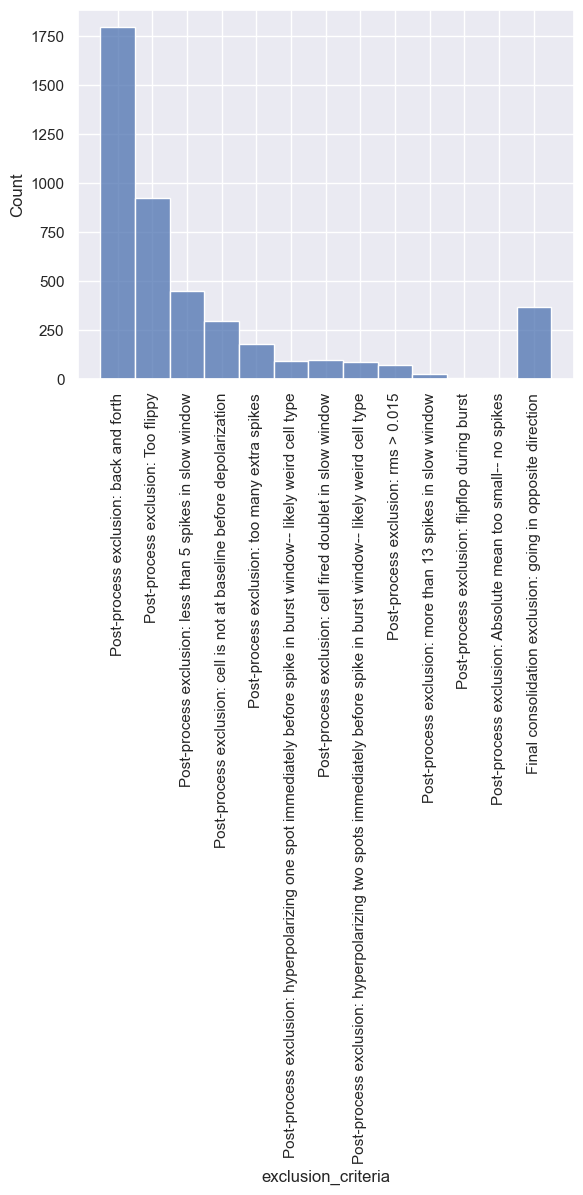

In [10]:
sns.histplot(data = exclusion, x = 'exclusion_criteria')
plt.xticks(rotation='vertical')

plt.show()